In [ ]:
# для загрузки данных
import pandas_datareader.data as web

# для анализа
import numpy as np
import pandas as pd
import statsmodels.api as sm

# для визуализации
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 6)

In [35]:
start = '2015-03-01'
end = '2020-03-01'

yndx = web.DataReader('YNDX', 'moex', start=start, end=end)
imoex = web.DataReader('IMOEX', 'moex', start=start, end=end)
yndx = yndx["CLOSE"]
imoex = imoex["CLOSE"]

# группируем по дням
yndx = yndx.groupby(pd.Grouper(freq='1D')).aggregate("mean")
imoex = imoex.groupby(pd.Grouper(freq='1D')).aggregate("mean")

# приводим к одному виду
yndx.index.rename("date", inplace=True);
yndx.rename("yndx_price", inplace=True);

imoex.index.rename("date", inplace=True);
imoex.rename("imoex_price", inplace=True);
df = pd.DataFrame([imoex, yndx]).T

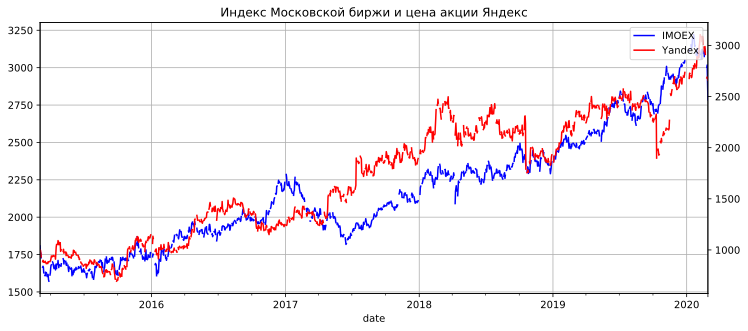

In [16]:
plt.figure(figsize=(12,5))
plt.title('Индекс Московской биржи и цена акции Яндекс')

ax1 = df.imoex_price.plot(color='blue', grid=True, label='IMOEX')
ax2 = df.yndx_price.plot(color='red', grid=True, secondary_y=True, label='Yandex')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [17]:
# для расчёта корреляции необходимо удалить пропущенные значения
corr = df.dropna().imoex_price.corr(
    df.dropna().yndx_price
)
"Correlation is {:.3}".format(corr)

'Correlation is 0.904'

In [18]:
pct_corr = df.dropna().imoex_price.pct_change().corr(
    df.dropna().yndx_price.pct_change()
)

"Percent change correlation is {:.3}".format(pct_corr)

'Percent change correlation is 0.405'

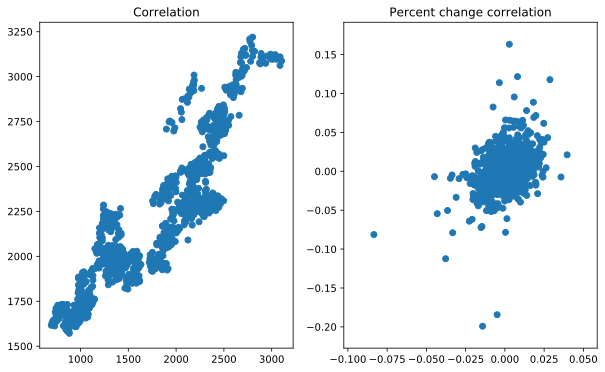

In [19]:
plt.subplot(1, 2, 1)
plt.scatter(
    df.dropna().yndx_price,
    df.dropna().imoex_price);
plt.title('Correlation')

plt.subplot(1, 2, 2)
plt.scatter(
    df.dropna().imoex_price.pct_change(),
    df.dropna().yndx_price.pct_change());
plt.title('Percent change correlation');


In [21]:
# Добавить константу в DataFrame x
reg_def = sm.add_constant(df.dropna())

# Регрессия у на х
result = sm.OLS(reg_def.imoex_price, reg_def[['const', 'yndx_price']]).fit()

# Вывести результат
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imoex_price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     5652.
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:08:04   Log-Likelihood:                -8226.6
No. Observations:                1260   AIC:                         1.646e+04
Df Residuals:                    1258   BIC:                         1.647e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1147.4635     14.482     79.234      0.000    1119.052    1175.875
yndx_price     0.5998      0.008     75.179      0.000       0.584       0.615
==============================================================================
Omnibus:                       28.943   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.346
Skew:                           0.374   Prob(JB):                     2.57e-07
Kurtosis:                       3.131   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
df_monthly = df.resample('M').last()
df_monthly.head()

,imoex_price,yndx_price
date,,
2015-03-31,1626.18,893.0
2015-04-30,1688.34,1001.0
2015-05-31,1609.19,941.0
2015-06-30,1654.55,848.0
2015-07-31,1669.00,882.0


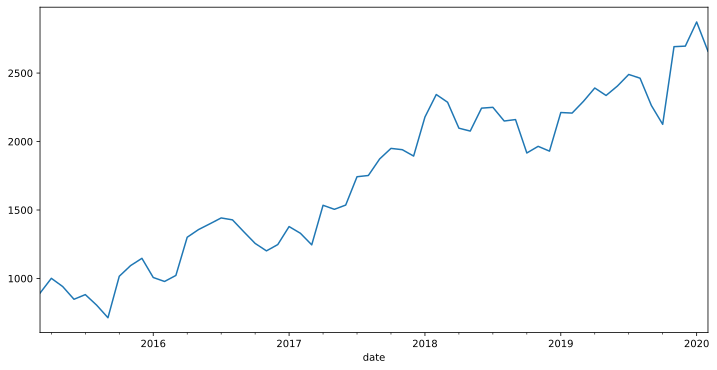

In [97]:
df_monthly.yndx_price.plot(figsize=(12,6))

In [99]:
df_monthly.yndx_price.describe()

count      60.000000
mean     1728.563333
std       584.611387
min       713.000000
25%      1247.000000
50%      1812.500000
75%      2220.000000
max      2873.400000
Name: yndx_price, dtype: float64

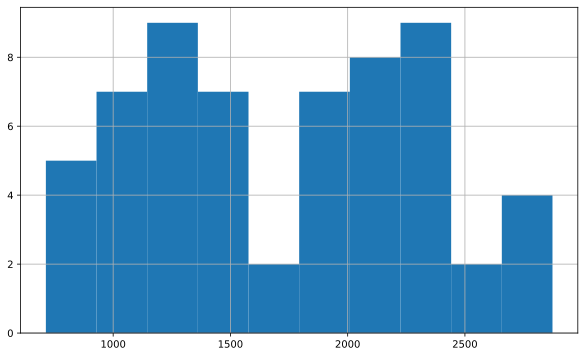

In [149]:
df_monthly.yndx_price.hist()

In [100]:
df_monthly.yndx_price.skew()

0.004149399413993521

In [101]:
df_monthly.yndx_price.kurtosis()

-1.22364638618391

In [106]:
test = sm.tsa.adfuller(df_monthly.yndx_price)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.8162300751788933
p-value:  0.8143080567480973
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
есть единичные корни, ряд не стационарен


In [109]:
yndx_price1 = df_monthly.yndx_price.diff(periods=1).dropna()

In [111]:
test = sm.tsa.adfuller(yndx_price1)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.2142539664022935
p-value:  5.413976015356287e-08
Critical values:  {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}
единичных корней нет, ряд стационарен


In [26]:
"Price autocorr {:.3}, Percent Change autocorr {:.3}".format(
    df_monthly.yndx_price.autocorr(),
    df_monthly.yndx_price.pct_change().autocorr()
)

'Price autocorr 0.969, Percent Change autocorr -0.0651'

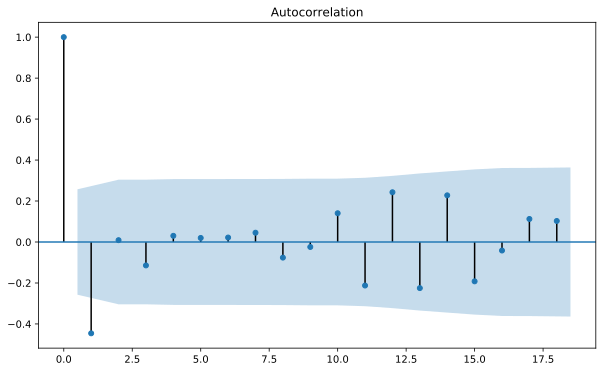

In [112]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf # для посчёта функции при разные значениях лага

plot_acf(yndx_price1.diff().dropna());

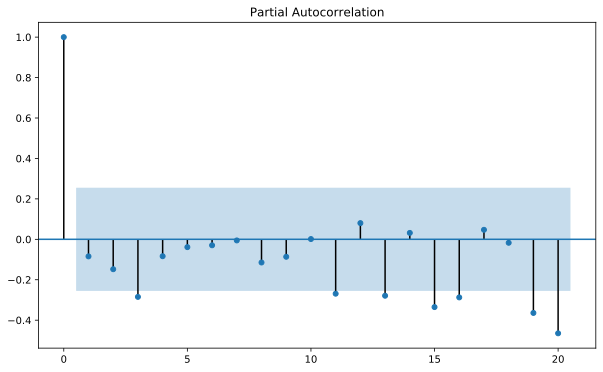

In [113]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(yndx_price1.dropna(), lags=20);

In [132]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_monthly.yndx_price, order=(1,1,1));
model_fit = model.fit();
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.yndx_price   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -372.148
Method:                       css-mle   S.D. of innovations            129.906
Date:                Sat, 25 Jul 2020   AIC                            752.295
Time:                        00:30:11   BIC                            760.605
Sample:                    04-30-2015   HQIC                           755.539
                         - 02-29-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 31.6916      2.581     12.280      0.000      26.633      36.750
ar.L1.D.yndx_price     0.6575      0.102      6.423      0.000       0.457       0.858
ma.L1.D.yndx_price    -0.9999      0.046    -21.693      0.000      -1.090      -0.910
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5209           +0.0000j            1.5209            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

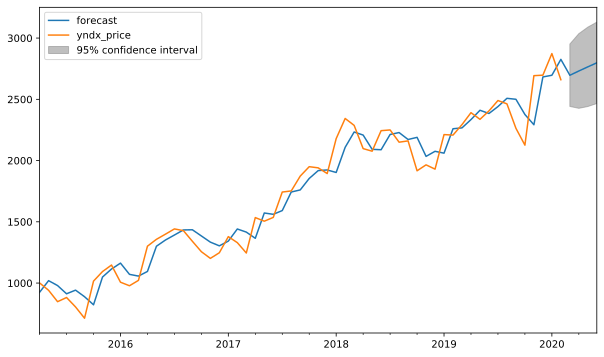

In [137]:
model_fit.plot_predict(end="30-06-2020");

In [146]:
q_test = sm.tsa.stattools.acf(model_fit.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.264859  0.606802
1    0.353944  0.837803
2    1.911013  0.591080
3    1.972145  0.740882
4    2.216823  0.818402
5    2.372015  0.882507
6    2.381398  0.935760
7    3.302805  0.913944
8    3.754162  0.926835
9    3.764400  0.957350
10   5.805761  0.886005
11   6.042347  0.913932
12   8.485395  0.810605
13   8.652927  0.852621
14  11.209225  0.737627
15  11.381027  0.785378
16  12.566162  0.764710
17  13.858103  0.738293
18  14.595671  0.747926
19  16.300073  0.697842
20  19.929346  0.525740
21  21.759612  0.474313
22  21.763391  0.534572
23  21.782453  0.592250
24  22.985158  0.578430
25  23.218150  0.620578
26  23.718332  0.645890
27  23.744907  0.694926
28  27.268304  0.557232
29  28.789393  0.528680
30  29.654557  0.535183
31  30.088654  0.563549
32  30.525714  0.590887
33  30.561079  0.636954
34  31.226313  0.650929
35  31.819707  0.667737
36  32.056825  0.699837
37  32.139577  0.736531
38  32.654443  0.753324
39  32.689758  0.787382


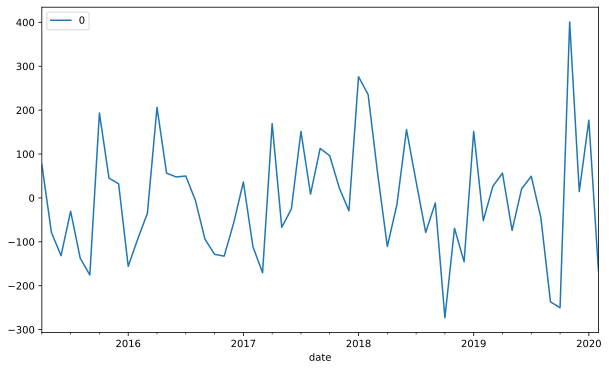

In [147]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [28]:
from statsmodels.tsa.stattools import adfuller
adfuller_p = adfuller(df_monthly['yndx_price'].fillna(method='ffill'))[1]

f"p-value of ADF-test {adfuller_p:.3}"

'p-value of ADF-test 0.814'

In [95]:
from statsmodels.tsa.arima_model import ARMA

# Прогноз модели AR (1)
mod = ARMA(df_monthly['yndx_price'].dropna(), order=(1, 0));
res = mod.fit();
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             yndx_price   No. Observations:                   60
Model:                     ARMA(1, 0)   Log Likelihood                -385.717
Method:                       css-mle   S.D. of innovations            145.884
Date:                Sat, 25 Jul 2020   AIC                            777.434
Time:                        00:03:02   BIC                            783.717
Sample:                    03-31-2015   HQIC                           779.892
                         - 02-29-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1758.7610    578.430      3.041      0.002     625.059    2892.463
ar.L1.yndx_price     0.9799      0.022     44.827      0.000       0.937       1.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0205           +0.0000j            1.0205            0.0000
-----------------------------------------------------------------------------
"""

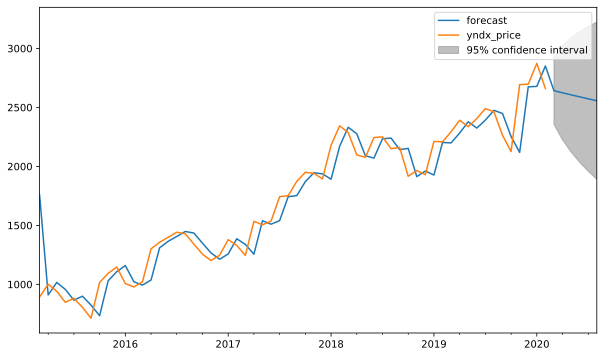

In [96]:
res.plot_predict(start=0, end="2020-08");

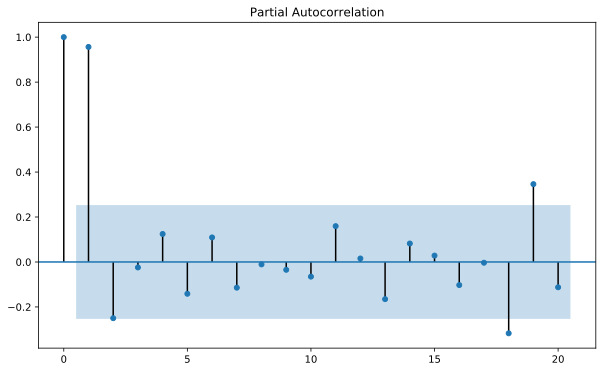

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_monthly['imoex_price'].dropna(), lags=20);

In [32]:
for order in range(1, 10):
    mod = ARMA(df_monthly['imoex_price'].dropna(), order=(order, 0))
    res = mod.fit();
    print("Order: {}\nBIC: {}\nAIC: {}\n".format(order, res.bic, res.aic))

Order: 1
BIC: 713.4851455987334
AIC: 707.2021119120672

Order: 2
BIC: 717.3761490226725
AIC: 708.9987707737841

Order: 3
BIC: 721.406551103148
AIC: 710.9348282920375

Order: 4
BIC: 725.1493383474656
AIC: 712.5832709741329

Order: 5
BIC: 727.8579003032557
AIC: 713.197488367701

Order: 6
BIC: 731.5320768776885
AIC: 714.7773203799117

Order: 7
BIC: 735.2078288785664
AIC: 716.3587278185674



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Order: 8
BIC: 743.7444162041676
AIC: 722.8009705819466

Order: 9
BIC: 742.3620089662421
AIC: 719.324218781799



In [87]:
plzl = web.DataReader('PLZL', 'moex', start=start, end=end)
plzl = plzl["CLOSE"]
df_monthly["plzl"] = plzl.resample('M').last()
gmkn = web.DataReader('GMKN', 'moex', start=start, end=end)
gmkn = gmkn["CLOSE"]
df_monthly["gmkn"] = gmkn.resample('M').last()

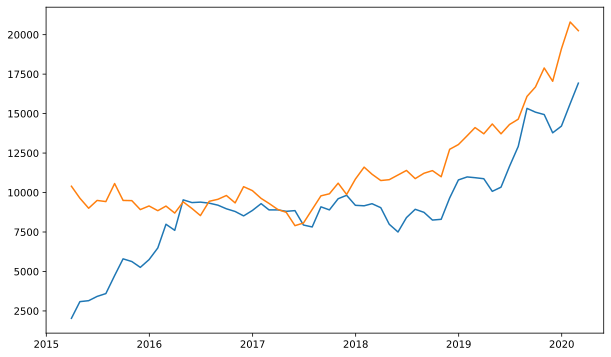

In [88]:
plt.plot(df_monthly.plzl*2, label='Полюс')
plt.plot(df_monthly.gmkn, label='Норникель');

In [90]:
reg_def = sm.add_constant(df_monthly.dropna())
result = sm.OLS(reg_def['plzl'], reg_def[['gmkn']]).fit()
result.params.gmkn

0.3976777008947194

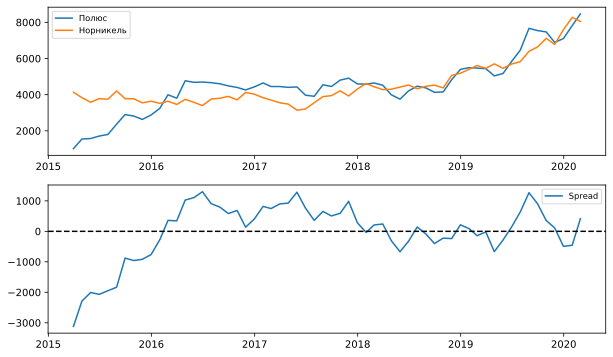

In [91]:
# График цены отдельно
plt.subplot(2,1,1)
plt.plot(df_monthly.plzl, label='Полюс')
plt.plot(df_monthly.gmkn  * result.params.gmkn, label='Норникель')
plt.legend(loc='best', fontsize='small')

# График распределения
plt.subplot(2,1,2)
plt.plot(df_monthly.plzl - df_monthly.gmkn * result.params.gmkn, label="Spread")
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k');

In [92]:
from statsmodels.tsa.stattools import adfuller

result_plzl = adfuller(df_monthly['plzl'])
result_gmkn = adfuller(df_monthly['gmkn'])
print(f"The p-value for the ADF test on Polyus is {result_plzl[1]:.2}, on Company Norilsk Nickel is {result_gmkn[1]:.2}")

result_spread = adfuller(df_monthly.plzl - df_monthly.gmkn * result.params.gmkn)
print(f"The p-value for the ADF test on the spread is {result_spread[1]:.2}")

The p-value for the ADF test on Polyus is 0.91, on Company Norilsk Nickel is 1.0
The p-value for the ADF test on the spread is 0.045
